In [ ]:
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import pickle
import copy
from scipy import stats
from scipy import stats
from numpy import linalg as LA
import seaborn as sns
import matplotlib.pylab as plt

def model_comp_test_assemble(V1,V2,cov1,cov2,U1,U2,N):
    Sigma11 = cov1
    Sigma22 = cov2
    Sigma21 = np.matmul(U2,U1.T)/(N**2)   
    Sigma12 = np.matmul(U1,U2.T)/(N**2)  
    Sigma = Sigma11 + Sigma22 - Sigma21 - Sigma12
    test_stat = np.matmul(np.matmul((V1-V2).T,np.linalg.inv(Sigma)),V1-V2).flatten()
    pvalue = 1 - stats.chi2.cdf(test_stat, V1.shape[0])
    return pvalue

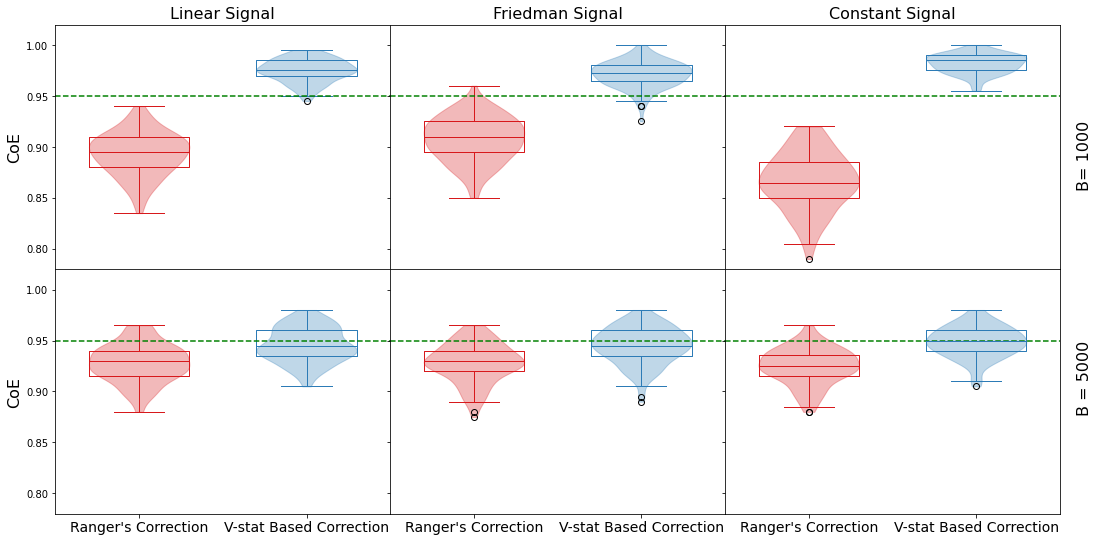

In [ ]:
# coverage comparison for RF with max_depth = 9
def define_box_properties(f,plot_name, color_code, label,label_plot):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    if label_plot == True:
        plt.plot([], c=color_code, label=label)
    else:
        plt.plot([], c=color_code)

ticks = ["Ranger\'s Correction", 'V-stat Based Correction']

def generate_plot(ax1,model_type,B,label_plot,order):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 100
    open_file = open("data/RF_"+model_type+"_B_"+str(n_estimators)+"_test100.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    j = len(result_rf[0])-1
    cov_ijc_ls = []
    cov_c_ls = []
    V_ls = []
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        cov_ij,cov_ijc, cov_c, cov_bias, U_ij,U_bias, V, V_bias = result_ls[j]
        cov_ijc_ls.append(cov_ijc)
        cov_c_ls.append(cov_c)
        V_ls.append(V)
    V_arr = np.concatenate(V_ls,1)
    V_mean = np.mean(V_arr,1)
    pvalue_ijc = np.zeros(n_test)
    pvalue_c = np.zeros(n_test)
    for k in range(n_test):
        for i in range(len(result_rf)):
            cov_ijc_k = np.max([cov_ijc_ls[i][k,k],0])
            cov_c_k = np.max([cov_c_ls[i][k,k],0])
            if (V_mean[k] - 1.96*np.sqrt(cov_ijc_k) < V_ls[i][k,0]) and (V_mean[k] + 1.96*np.sqrt(cov_ijc_k) > V_ls[i][k,0]):
                pvalue_ijc[k] = pvalue_ijc[k] + 1/len(result_rf)
            if (V_mean[k] - 1.96*np.sqrt(cov_c_k) < V_ls[i][k,0]) and (V_mean[k] + 1.96*np.sqrt(cov_c_k) > V_ls[i][k,0]):
                pvalue_c[k] = pvalue_c[k] + 1/len(result_rf)

    bp1 = ax1.boxplot(pvalue_ijc,positions=[1],widths=0.6)
    v1 = ax1.violinplot(pvalue_ijc,positions=[1],widths=0.6,showextrema=False)
    bp2 = ax1.boxplot(pvalue_c,positions=[2],widths=0.6)
    v2 = ax1.violinplot(pvalue_c,positions=[2],widths=0.6,showextrema=False)
    define_box_properties(f,bp1, '#D7191C', 'Random Initialization',label_plot)
    define_box_properties(f,v1, '#D7191C', 'Random Initialization',label_plot)
    define_box_properties(f,bp2, '#2C7BB6', 'Fix Seed',label_plot)
    define_box_properties(f,v2, '#2C7BB6', 'Fix Seed',label_plot)
    ax1.axhline(y=0.95, color='green', linestyle='--')
    
    ax1.set_xticks(np.arange(1, 3, 1));
    ax1.set_xticklabels(ticks,fontsize= 14)
    if order == 1 or order == 4:
        ax1.set_ylabel('CoE', fontsize=16)
    if order == 1 or order == 2 or order == 3:
        if model_type == "linear":
            ax1.set_title("Linear Signal", fontsize=16)
        elif model_type == "friedman":
            ax1.set_title("Friedman Signal", fontsize=16)
        elif model_type == "constant":
            ax1.set_title("Constant Signal", fontsize=16) 
    ax1.set_ylim([0.78,1.02])
f, ax = plt.subplots(2, 3, figsize=(18,9), sharex=True, sharey=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
generate_plot(ax[0,0],"linear",1000,True,1)
generate_plot(ax[0,1],"friedman",1000,False,2)
generate_plot(ax[0,2],"constant",1000,False,3)
generate_plot(ax[1,0],"linear",5000,False,4)
generate_plot(ax[1,1],"friedman",5000,False,5)
generate_plot(ax[1,2],"constant",5000,False,6)
plt.text(2.6, 1.1, 'B= 1000', size=16,rotation="vertical")
plt.text(2.6, 0.88, 'B = 5000', size=16,rotation="vertical")
plt.show()

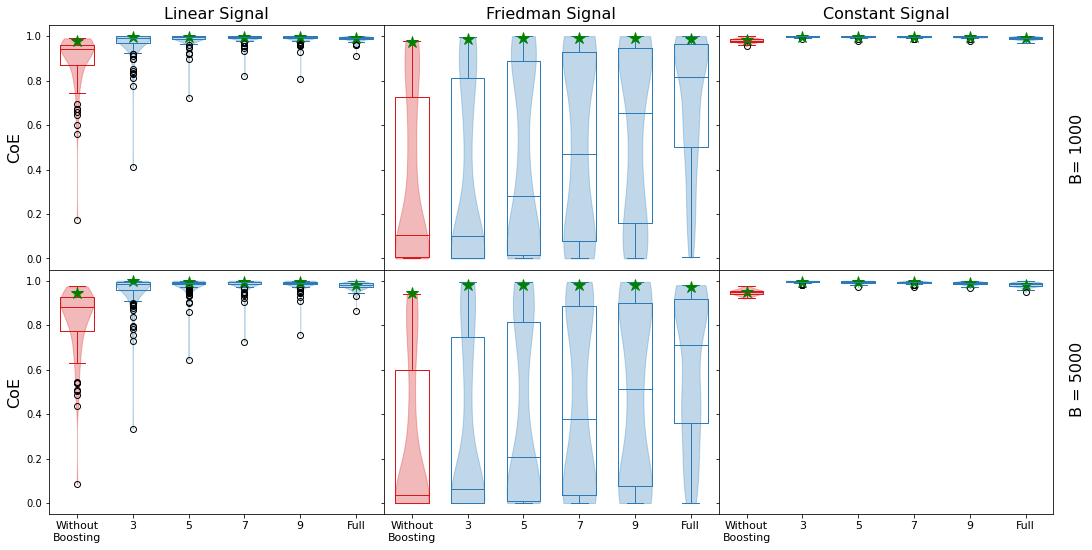

In [ ]:
# RF boost RF
def define_box_properties(f,plot_name, color_code, label,label_plot):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    if label_plot == True:
        plt.plot([], c=color_code, label=label)
    else:
        plt.plot([], c=color_code)

ticks = [ 'Without\nBoosting', "3","5","7","9","Full"]

def generate_plot(ax1,model_type,B,label_plot,order):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 100
    d = 6
    open_file = open("data/RF_boost_"+model_type+"_B_"+str(n_estimators)+"_test100.pkl", "rb")
    result_rf = pickle.load(open_file)
     
    open_file.close()

    np.random.seed(2021)
    X_test = np.random.uniform(-1,1,size=d*n_test).reshape([-1,d])

    if model_type == "friedman":
        true = (10 * np.sin(np.pi*X_test[:,0]*X_test[:,1]) + 20*(X_test[:,2]-0.5)**2 + 10 * X_test[:,3] + 5 * X_test[:,4]).reshape([-1,1])
    elif model_type == "linear":
        true = (np.sum(X_test[:,:4],1)).reshape([-1,1])
    elif model_type == "constant":
        true = (np.ones(N)*2).reshape([-1,1])
    pvalue2_ls = []
    pvalue_exp2_ls = []
    for j in range(5):
        Sigma1_ls = []
        Sigma2_ls = []
        V1_ls = []
        V2_ls = []
        for i in range(len(result_rf)):
            result_ls = result_rf[i]
            cov_ij1,cov_ijc1, cov_c1, U_ij1, V1, _ = result_ls[j][0]
            cov_ij2,cov_ijc2, cov_c2, U_ij2, V2, _ = result_ls[j][1]
            Sigma11 = cov_c1
            Sigma22 = cov_c2
            Sigma21 = np.matmul(U_ij1,U_ij2.T)/(N**2)   
            Sigma12 = np.matmul(U_ij2,U_ij1.T)/(N**2)  
            Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
            Sigma1_ls.append(cov_c1)
            Sigma2_ls.append(Sigma2)
            V1_ls.append(V1)
            V2_ls.append(V1+V2)

        V1_arr = np.concatenate(V1_ls,1)
        V1_mean = np.mean(V1_arr,1)
        V2_arr = np.concatenate(V2_ls,1)
        V2_mean = np.mean(V2_arr,1)

        pvalue1 = np.zeros(n_test)
        pvalue2 = np.zeros(n_test)
        for k in range(n_test):
            for i in range(len(result_rf)):
                Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
                Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
                if (V1_ls[i][k,0] - 1.96*np.sqrt(Sigma1_k) < true[k]) and (V1_ls[i][k,0] + 1.96*np.sqrt(Sigma1_k) > true[k]):
                    pvalue1[k] = pvalue1[k] + 1/len(result_rf)
                if (V2_ls[i][k,0] - 1.96*np.sqrt(Sigma2_k) < true[k]) and (V2_ls[i][k,0] + 1.96*np.sqrt(Sigma2_k) > true[k]):
                    pvalue2[k] = pvalue2[k] + 1/len(result_rf)
        pvalue2_ls.append(pvalue2)

        pvalue_exp1 = np.zeros(n_test)
        pvalue_exp2 = np.zeros(n_test)
        for k in range(n_test):
            for i in range(len(result_rf)):
                Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
                Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
                if (V1_ls[i][k,0] - 1.96*np.sqrt(Sigma1_k) < V1_mean[k]) and (V1_ls[i][k,0] + 1.96*np.sqrt(Sigma1_k) > V1_mean[k]):
                    pvalue_exp1[k] = pvalue_exp1[k] + 1/len(result_rf)
                if (V2_ls[i][k,0] - 1.96*np.sqrt(Sigma2_k) < V2_mean[k]) and (V2_ls[i][k,0] + 1.96*np.sqrt(Sigma2_k) > V2_mean[k]):
                    pvalue_exp2[k] = pvalue_exp2[k] + 1/len(result_rf)
        pvalue_exp2_ls.append(pvalue_exp2)

    bp1 = ax1.boxplot(pvalue1,positions=[1],widths=0.6)
    bp21 = ax1.boxplot(pvalue2_ls[0],positions=[2],widths=0.6)
    bp22 = ax1.boxplot(pvalue2_ls[1],positions=[3],widths=0.6)
    bp23 = ax1.boxplot(pvalue2_ls[2],positions=[4],widths=0.6)
    bp24 = ax1.boxplot(pvalue2_ls[3],positions=[5],widths=0.6)
    bp25 = ax1.boxplot(pvalue2_ls[4],positions=[6],widths=0.6)

    v1 = ax1.violinplot(pvalue1,positions=[1],widths=0.6,showextrema=False)
    v21 = ax1.violinplot(pvalue2_ls[0],positions=[2],widths=0.6,showextrema=False)
    v22 = ax1.violinplot(pvalue2_ls[1],positions=[3],widths=0.6,showextrema=False)
    v23 = ax1.violinplot(pvalue2_ls[2],positions=[4],widths=0.6,showextrema=False)
    v24 = ax1.violinplot(pvalue2_ls[3],positions=[5],widths=0.6,showextrema=False)
    v25 = ax1.violinplot(pvalue2_ls[4],positions=[6],widths=0.6,showextrema=False)

    define_box_properties(f,bp1, '#D7191C', 'Without Boosting',label_plot)
    define_box_properties(f,bp21, '#2C7BB6', '3',label_plot)
    define_box_properties(f,bp22, '#2C7BB6', '5',label_plot)
    define_box_properties(f,bp23, '#2C7BB6', '7',label_plot)
    define_box_properties(f,bp24, '#2C7BB6', '9',label_plot)
    define_box_properties(f,bp25, '#2C7BB6', 'Full',label_plot)

    define_box_properties(f,v1, '#D7191C', 'Without Boosting',label_plot)
    define_box_properties(f,v21, '#2C7BB6', '3',label_plot)
    define_box_properties(f,v22, '#2C7BB6', '5',label_plot)
    define_box_properties(f,v23, '#2C7BB6', '7',label_plot)
    define_box_properties(f,v24, '#2C7BB6', '9',label_plot)
    define_box_properties(f,v25, '#2C7BB6', 'Full',label_plot)

    ax1.set_xticks(np.arange(1, 7, 1));
    ax1.set_xticklabels(ticks,fontsize= 11)

    ax1.plot(1,np.mean(pvalue_exp1),"*",color = 'green',markersize=13)
    ax1.plot(2,np.mean(pvalue_exp2_ls[0]),"*",color = 'green',markersize=13)
    ax1.plot(3,np.mean(pvalue_exp2_ls[1]),"*",color = 'green',markersize=13)
    ax1.plot(4,np.mean(pvalue_exp2_ls[2]),"*",color = 'green',markersize=13)
    ax1.plot(5,np.mean(pvalue_exp2_ls[3]),"*",color = 'green',markersize=13)
    ax1.plot(6,np.mean(pvalue_exp2_ls[4]),"*",color = 'green',markersize=13)

    if order == 1 or order == 4:
        ax1.set_ylabel('CoE', fontsize=16)
    if order == 1 or order == 2 or order == 3:
        if model_type == "linear":
            ax1.set_title("Linear Signal", fontsize=16)
        elif model_type == "friedman":
            ax1.set_title("Friedman Signal", fontsize=16)
        elif model_type == "constant":
            ax1.set_title("Constant Signal", fontsize=16) 
    ax1.set_ylim([-0.05,1.05])

f, ax = plt.subplots(2, 3, figsize=(18,9), sharex=True, sharey=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
generate_plot(ax[0,0],"linear",1000,True,1)
generate_plot(ax[0,1],"friedman",1000,False,2)
generate_plot(ax[0,2],"constant",1000,False,3)
generate_plot(ax[1,0],"linear",5000,False,4)
generate_plot(ax[1,1],"friedman",5000,False,5)
generate_plot(ax[1,2],"constant",5000,False,6)
plt.text(6.8, 1.45, 'B= 1000', size=16,rotation="vertical")
plt.text(6.8, 0.4, 'B = 5000', size=16,rotation="vertical")
plt.show()

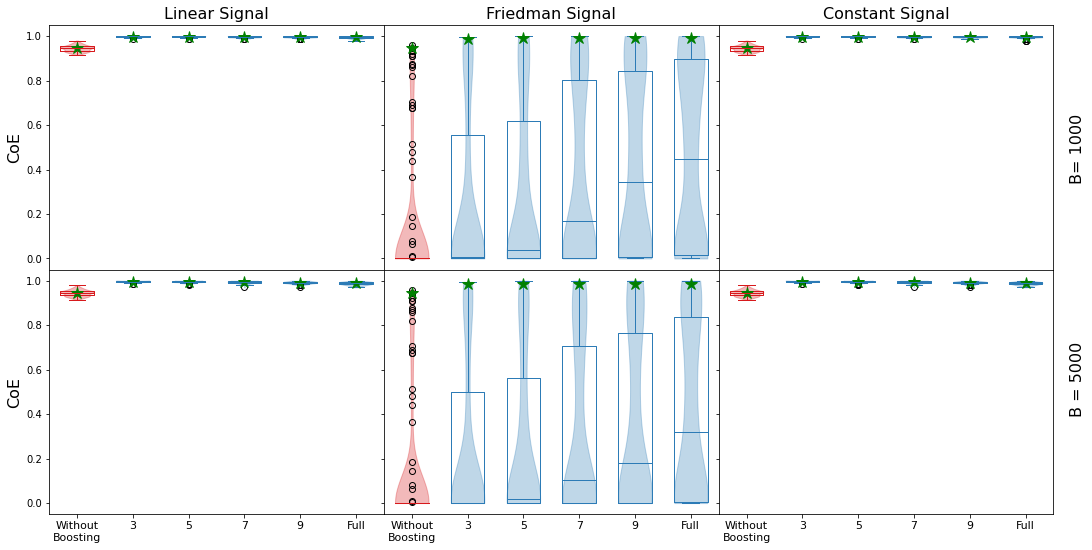

In [ ]:
# RF boost GLM
def define_box_properties(f,plot_name, color_code, label,label_plot):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    if label_plot == True:
        plt.plot([], c=color_code, label=label)
    else:
        plt.plot([], c=color_code)

ticks = [ 'Without\nBoosting', "3","5","7","9","Full"]

def generate_plot(ax1,model_type,B,label_plot,order):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 100
    d = 6
    open_file = open("data/LM_boost_"+model_type+"_B_"+str(n_estimators)+"_test100.pkl", "rb")   
    result_rf = pickle.load(open_file)
     
    open_file.close()

    np.random.seed(2021)
    X_test = np.random.uniform(-1,1,size=d*n_test).reshape([-1,d])

    if model_type == "friedman":
        true = (10 * np.sin(np.pi*X_test[:,0]*X_test[:,1]) + 20*(X_test[:,2]-0.5)**2 + 10 * X_test[:,3] + 5 * X_test[:,4]).reshape([-1,1])
    elif model_type == "linear":
        true = (np.sum(X_test[:,:4],1)).reshape([-1,1])
    elif model_type == "constant":
        true = (np.ones(N)*2).reshape([-1,1])
    pvalue2_ls = []
    pvalue_exp2_ls = []
    for j in range(5):
        Sigma1_ls = []
        Sigma2_ls = []
        V1_ls = []
        V2_ls = []
        for i in range(len(result_rf)):
            result_ls = result_rf[i]
            Sigma1, U, _, V1 = result_ls[j][0]
            try:
                cov_ij,cov_ijc, cov_c, U_ij, V2,_ = result_ls[j][1]
            except:
                cov_ij,cov_ijc, cov_c, U_ij, V2 = result_ls[j][1]
            Sigma11 = Sigma1
            Sigma22 = cov_c
            Sigma21 = np.matmul(U_ij,U.T)/(N**2)   
            Sigma12 = np.matmul(U,U_ij.T)/(N**2)  
            Sigma2 = Sigma11 + Sigma22 + Sigma21 + Sigma12
            Sigma1_ls.append(Sigma1)
            Sigma2_ls.append(Sigma2)
            V1_ls.append(V1)
            V2_ls.append(V1+V2)

        V1_arr = np.concatenate(V1_ls,1)
        V1_mean = np.mean(V1_arr,1)
        V2_arr = np.concatenate(V2_ls,1)
        V2_mean = np.mean(V2_arr,1)

        pvalue1 = np.zeros(n_test)
        pvalue2 = np.zeros(n_test)
        for k in range(n_test):
            for i in range(len(result_rf)):
                Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
                Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
                if (V1_ls[i][k,0] - 1.96*np.sqrt(Sigma1_k) < true[k]) and (V1_ls[i][k,0] + 1.96*np.sqrt(Sigma1_k) > true[k]):
                    pvalue1[k] = pvalue1[k] + 1/len(result_rf)
                if (V2_ls[i][k,0] - 1.96*np.sqrt(Sigma2_k) < true[k]) and (V2_ls[i][k,0] + 1.96*np.sqrt(Sigma2_k) > true[k]):
                    pvalue2[k] = pvalue2[k] + 1/len(result_rf)
        pvalue2_ls.append(pvalue2)

        pvalue_exp1 = np.zeros(n_test)
        pvalue_exp2 = np.zeros(n_test)
        for k in range(n_test):
            for i in range(len(result_rf)):
                Sigma1_k = np.max([Sigma1_ls[i][k,k],0])
                Sigma2_k = np.max([Sigma2_ls[i][k,k],0])
                if (V1_ls[i][k,0] - 1.96*np.sqrt(Sigma1_k) < V1_mean[k]) and (V1_ls[i][k,0] + 1.96*np.sqrt(Sigma1_k) > V1_mean[k]):
                    pvalue_exp1[k] = pvalue_exp1[k] + 1/len(result_rf)
                if (V2_ls[i][k,0] - 1.96*np.sqrt(Sigma2_k) < V2_mean[k]) and (V2_ls[i][k,0] + 1.96*np.sqrt(Sigma2_k) > V2_mean[k]):
                    pvalue_exp2[k] = pvalue_exp2[k] + 1/len(result_rf)
        pvalue_exp2_ls.append(pvalue_exp2)

    bp1 = ax1.boxplot(pvalue1,positions=[1],widths=0.6)
    bp21 = ax1.boxplot(pvalue2_ls[0],positions=[2],widths=0.6)
    bp22 = ax1.boxplot(pvalue2_ls[1],positions=[3],widths=0.6)
    bp23 = ax1.boxplot(pvalue2_ls[2],positions=[4],widths=0.6)
    bp24 = ax1.boxplot(pvalue2_ls[3],positions=[5],widths=0.6)
    bp25 = ax1.boxplot(pvalue2_ls[4],positions=[6],widths=0.6)

    v1 = ax1.violinplot(pvalue1,positions=[1],widths=0.6,showextrema=False)
    v21 = ax1.violinplot(pvalue2_ls[0],positions=[2],widths=0.6,showextrema=False)
    v22 = ax1.violinplot(pvalue2_ls[1],positions=[3],widths=0.6,showextrema=False)
    v23 = ax1.violinplot(pvalue2_ls[2],positions=[4],widths=0.6,showextrema=False)
    v24 = ax1.violinplot(pvalue2_ls[3],positions=[5],widths=0.6,showextrema=False)
    v25 = ax1.violinplot(pvalue2_ls[4],positions=[6],widths=0.6,showextrema=False)

    define_box_properties(f,bp1, '#D7191C', 'Without Boosting',label_plot)
    define_box_properties(f,bp21, '#2C7BB6', '3',label_plot)
    define_box_properties(f,bp22, '#2C7BB6', '5',label_plot)
    define_box_properties(f,bp23, '#2C7BB6', '7',label_plot)
    define_box_properties(f,bp24, '#2C7BB6', '9',label_plot)
    define_box_properties(f,bp25, '#2C7BB6', 'Full',label_plot)

    define_box_properties(f,v1, '#D7191C', 'Without Boosting',label_plot)
    define_box_properties(f,v21, '#2C7BB6', '3',label_plot)
    define_box_properties(f,v22, '#2C7BB6', '5',label_plot)
    define_box_properties(f,v23, '#2C7BB6', '7',label_plot)
    define_box_properties(f,v24, '#2C7BB6', '9',label_plot)
    define_box_properties(f,v25, '#2C7BB6', 'Full',label_plot)

    ax1.set_xticks(np.arange(1, 7, 1));
    ax1.set_xticklabels(ticks,fontsize= 11)

    ax1.plot(1,np.mean(pvalue_exp1),"*",color = 'green',markersize=13)
    ax1.plot(2,np.mean(pvalue_exp2_ls[0]),"*",color = 'green',markersize=13)
    ax1.plot(3,np.mean(pvalue_exp2_ls[1]),"*",color = 'green',markersize=13)
    ax1.plot(4,np.mean(pvalue_exp2_ls[2]),"*",color = 'green',markersize=13)
    ax1.plot(5,np.mean(pvalue_exp2_ls[3]),"*",color = 'green',markersize=13)
    ax1.plot(6,np.mean(pvalue_exp2_ls[4]),"*",color = 'green',markersize=13)
    
    if order == 1 or order == 4:
        ax1.set_ylabel('CoE', fontsize=16)
    if order == 1 or order == 2 or order == 3:
        if model_type == "linear":
            ax1.set_title("Linear Signal", fontsize=16)
        elif model_type == "friedman":
            ax1.set_title("Friedman Signal", fontsize=16)
        elif model_type == "constant":
            ax1.set_title("Constant Signal", fontsize=16) 
    ax1.set_ylim([-0.05,1.05])

f, ax = plt.subplots(2, 3, figsize=(18,9), sharex=True, sharey=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0)
generate_plot(ax[0,0],"linear",1000,True,1)
generate_plot(ax[0,1],"friedman",1000,False,2)
generate_plot(ax[0,2],"constant",1000,False,3)
generate_plot(ax[1,0],"linear",5000,False,4)
generate_plot(ax[1,1],"friedman",5000,False,5)
generate_plot(ax[1,2],"constant",5000,False,6)
plt.text(6.8, 1.45, 'B= 1000', size=16,rotation="vertical")
plt.text(6.8, 0.4, 'B = 5000', size=16,rotation="vertical")
plt.show()

In [ ]:
file = 'data/df_info'
with open(file+'.pkl', 'rb') as f:
        df_all = pickle.load(f)

def define_box_properties(f,plot_name, color_code, label,label_plot):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    if label_plot == True:
      plt.plot([], c=color_code, label=label)
    else:
      plt.plot([], c=color_code)

def define_box_properties_v(f,plot_name, color_code, label,label_plot):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

ticks = [' 1', ' 3', ' 5', ' 10', ' 20']

def generate_plot(ax1,node,df_type,label_plot,order):
    if node<12:
        N = 5000
    else:
        N = 1000
    if node%3 == 0:
        model_type = "Linear"
    elif node%3 == 1:
        model_type = "Friedman"
    elif node%3 == 2:
        model_type = "Constant"
    if (node<6) or ((11<node) and (node)<18):
        act = "\"Relu\""
    else:
        act = "\"Sigmoid\""

    df1 = np.array([item[df_type] for item in df_all[node]]).T
    df2 = np.array([item[df_type] for item in df_all[node+3]]).T
    bp1 = ax1.boxplot(df1,positions=np.array(np.arange(5))*2.0-0.35,widths=0.6)
    bp2 = ax1.boxplot(df2,positions=np.array(np.arange(5))*2.0+0.35,widths=0.6)
    v1 = ax1.violinplot(df1,positions=np.array(np.arange(5))*2.0-0.35,widths=0.6,showextrema=False)
    v2 = ax1.violinplot(df2,positions=np.array(np.arange(5))*2.0+0.35,widths=0.6,showextrema=False)
    # setting colors for each groups
    define_box_properties(f,bp1, '#D7191C', 'Random Initialization',label_plot)
    define_box_properties(f,bp2, '#2C7BB6', 'Fixed Initialization',label_plot)
    define_box_properties_v(f,v1, '#D7191C', 'Random Initialization',label_plot)
    define_box_properties_v(f,v2, '#2C7BB6', 'Fixed Initialization',label_plot)
    ax1.set_xticks(np.arange(0, len(ticks) * 2, 2));
    ax1.set_xticklabels(ticks,fontsize= 14)
    if order == 4 or order == 5 or order == 6:
        ax1.set_xlabel('Number of Hidden Units', fontsize=14)
    if order == 1 or order == 4:
        if df_type == "MC_var":
            ax1.set_ylabel('Monto Carlo Variance', fontsize=16)
        else:
            ax1.set_ylabel('CoE', fontsize=16)
    if order == 1 or order == 2 or order == 3:
        ax1.set_title(model_type + " Signal",fontsize= 16)

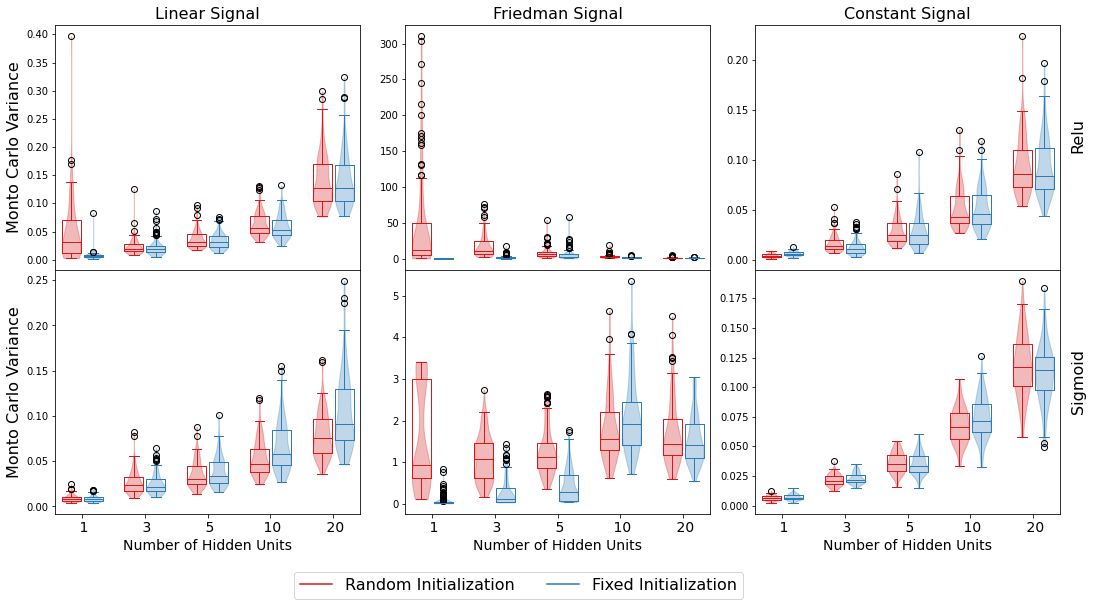

In [ ]:
# N = 1000
df_type = "MC_var"
f, ax = plt.subplots(2, 3, figsize=(18,9), sharex=True)
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.15)
generate_plot(ax[0,0],12,df_type,True,1)
generate_plot(ax[0,1],13,df_type,False,2)
generate_plot(ax[0,2],14,df_type,False,3)
generate_plot(ax[1,0],18,df_type,False,4)
generate_plot(ax[1,1],19,df_type,False,5)
generate_plot(ax[1,2],20,df_type,False,6)
f.legend(loc="lower center", borderaxespad=0.1, prop={'size':16}, bbox_to_anchor=(0.4,0),fancybox=True, ncol=2)
plt.text(9.2, 0.3, 'Relu', size=16,rotation="vertical")
plt.text(9.2, 0.08, 'Sigmoid', size=16,rotation="vertical")
plt.show()

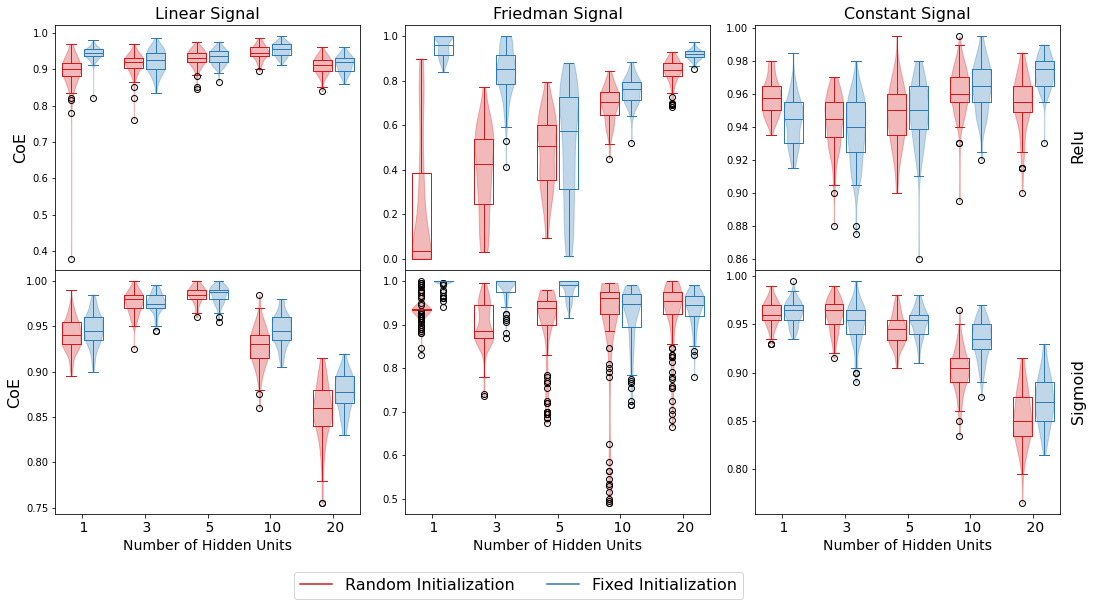

In [ ]:
# N = 1000
df_type = "Coverage_Debiased"
f, ax = plt.subplots(2, 3, figsize=(18,9))
f.subplots_adjust(hspace=0)
f.subplots_adjust(wspace=0.15)
generate_plot(ax[0,0],12,df_type,True,1)
generate_plot(ax[0,1],13,df_type,False,2)
generate_plot(ax[0,2],14,df_type,False,3)
generate_plot(ax[1,0],18,df_type,False,4)
generate_plot(ax[1,1],19,df_type,False,5)
generate_plot(ax[1,2],20,df_type,False,6)
f.legend(loc="lower center", borderaxespad=0.1, prop={'size':16}, bbox_to_anchor=(0.4,0),fancybox=True, ncol=2)
plt.text(9.2, 1.12, 'Relu', size=16,rotation="vertical")
plt.text(9.2, 0.85, 'Sigmoid', size=16,rotation="vertical")
plt.show()

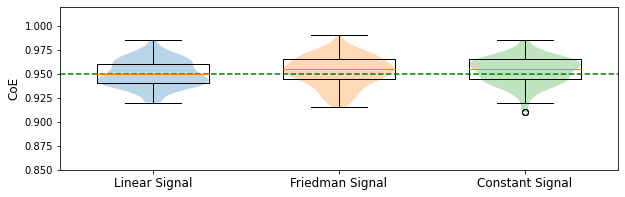

In [ ]:
# coverage of XGboost
def define_box_properties(f,plot_name, color_code):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)

ticks = ["Linear Signal", 'Friedman Signal',"Constant Signal"]

def generate_plot(label_plot):
    N = 1000
    s_frac = 0.2
    n_test = 100

    pvalue_ls = []
    for model_type in ["linear","friedman","constant"]:
        open_file = open("data/XGB_"+model_type+"_B_1000_test100.pkl", "rb")
        result_rf = pickle.load(open_file)
        open_file.close()

        cov_ijc_ls = []
        cov_c_ls = []
        V_ls = []
        for i in range(len(result_rf)):
            result_ls = result_rf[i]
            cov_ij,cov_ijc, cov_c, U_ij, V = result_ls
            cov_ijc_ls.append(cov_ijc)
            cov_c_ls.append(cov_c)
            V_ls.append(V)
        V_arr = np.concatenate(V_ls,1)
        V_mean = np.mean(V_arr,1)
        pvalue_c = np.zeros(n_test)
        for k in range(n_test):
            for i in range(len(result_rf)):
                cov_c_k = np.max([cov_c_ls[i][k,k],0])
                if (V_mean[k] - 1.96*np.sqrt(cov_c_k) < V_ls[i][k,0]) and (V_mean[k] + 1.96*np.sqrt(cov_c_k) > V_ls[i][k,0]):
                    pvalue_c[k] = pvalue_c[k] + 1/len(result_rf)
        pvalue_ls.append(pvalue_c)

    bp1 = plt.boxplot(pvalue_ls[0],positions=[1],widths=0.6)
    bp2 = plt.boxplot(pvalue_ls[1],positions=[2],widths=0.6)
    bp3 = plt.boxplot(pvalue_ls[2],positions=[3],widths=0.6)
    v1 = plt.violinplot(pvalue_ls[0],positions=[1],widths=0.6,showextrema=False)
    v2 = plt.violinplot(pvalue_ls[1],positions=[2],widths=0.6,showextrema=False)
    v3 = plt.violinplot(pvalue_ls[2],positions=[3],widths=0.6,showextrema=False)
    # define_box_properties(f,bp1, "#D7191C")
    # define_box_properties(f,bp2, "#D7191C")
    # define_box_properties(f,bp3, "#D7191C")
    # define_box_properties(f,v1, "#D7191C")
    # define_box_properties(f,v2, "#D7191C")
    # define_box_properties(f,v3, "#D7191C")
    plt.axhline(y=0.95, color='green', linestyle='--')
    
    plt.xticks(np.arange(1, 4, 1),labels=ticks,fontsize= 12);
    plt.ylabel('CoE', fontsize=12)
    plt.ylim([0.85,1.02])
plt.figure(figsize=[10,3])
generate_plot(True)
plt.show()

In [ ]:
# comparison of RF and glm
def generate_plot(model_type,B):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 5
    open_file = open("data/RF_"+model_type+"_B_"+str(n_estimators)+"_test5.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    open_file = open("data/LM_"+model_type+"_test5.pkl", "rb")
    result_glm = pickle.load(open_file)
    open_file.close()

    result_all = []
    for i in range(len(result_rf)):
        result = []
        for item in result_rf[i]:
            result.append([item[2],item[4],item[5]])
        result.append(result_glm[i])
        result_all.append(result)

    param_dict = ["3","5","7","9","Full","LM"]
    power_mat = np.zeros([len(param_dict),len(param_dict)])
    for i in range(len(result_all)):
        result_ls = result_all[i]
        for j0 in range(len(result_ls)-1):
            j = j0+1
            for k in range(j):
                cov1, U_ij1, V1 = result_ls[j]
                cov2, U_ij2, V2 = result_ls[k]
                pvalue = model_comp_test_assemble(V1,V2,cov1,cov2,U_ij1,U_ij2,N)
                if pvalue<0.05:
                    power_mat[len(param_dict)-k-1,j] += 1/len(result_all)

    return power_mat[1:,:]

power_mat1 = generate_plot("linear",1000)
power_mat2 = generate_plot("friedman",1000)
power_mat3 = generate_plot("constant",1000)
power_mat4 = generate_plot("linear",5000)
power_mat5 = generate_plot("friedman",5000)
power_mat6 = generate_plot("constant",5000)
power_mat = [power_mat1,power_mat2,power_mat3,power_mat4,power_mat5,power_mat6]

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


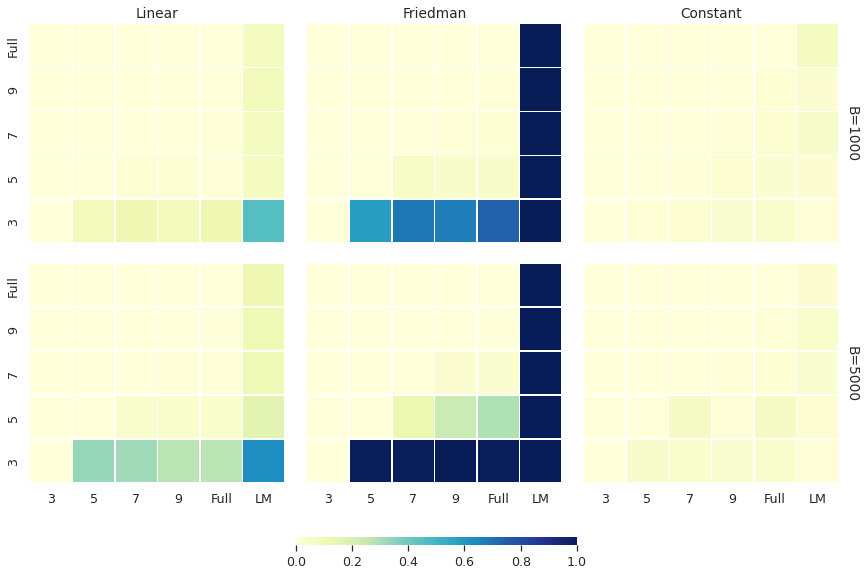

In [ ]:
param_dict = ["3","5","7","9","Full","LM"]
y_ls = ["Full","9","7","5","3"]
d = {'xlab':[],'ylab':[],'model_type':[],'B':[],'count':[]}
data = pd.DataFrame(data=d)
c = 0
i = 0
for B in ["B=1000","B=5000"]:
    for model_type in ["Linear","Friedman","Constant"]:
        for k in range(len(param_dict)-1):
            for j in range(len(param_dict)):
                data.loc[c] = [param_dict[j],y_ls[k],model_type,B,power_mat[i][len(param_dict)-2-k,j]]
                c += 1
        i +=1

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='ylab', columns="xlab", values='count')
    sns.heatmap(data, linewidth=0.5, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"}, **kws)  # <-- Pass kwargs to heatmap

sns.set(font_scale=1.15)
g = sns.FacetGrid(data, col="model_type", row="B", margin_titles=True, despine=False)

cbar_ax = g.fig.add_axes([0.37, 0.02, .3, .015])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1)  # <-- Specify the colorbar axes and limits
g.set(xlabel=None)
g.set(ylabel=None)
g.set_yticklabels(["Full","9","7","5","3"])
g.fig.set_figwidth(13)
g.fig.set_figheight(8)
g.set_titles(row_template="{row_name}",col_template="{col_name}", fontsize=30)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


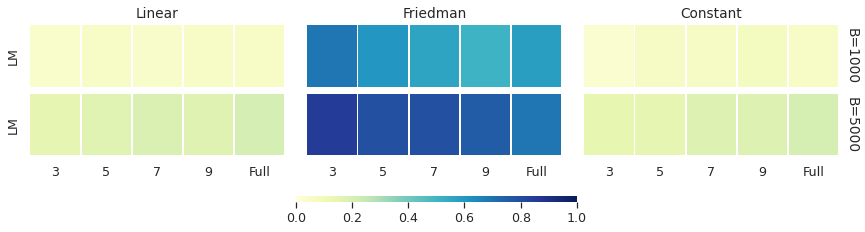

In [ ]:
from scipy.stats.morestats import BartlettResult
# comparison of Boosted RF
def generate_plot(model_type,B):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 5
    open_file = open("data/LM_boost_"+model_type+"_B_"+str(n_estimators)+"_test100.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()

    param_dict = ["3","5","7","9","Full"]
    power_mat = np.zeros([1,len(param_dict)])
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        for j in range(len(result_ls)):
            try:
                cov_ij,cov_ijc, cov_c2, U_ij, V2,_ = result_ls[j][1]
            except:
                cov_ij,cov_ijc, cov_c2, U_ij, V2 = result_ls[j][1]
            test_stat = np.matmul(np.matmul(V2.T,np.linalg.inv(cov_c2)),V2).flatten()
            pvalue = 1 - stats.chi2.cdf(test_stat, V2.shape[0])
            if pvalue<0.05:
                power_mat[:,j] += 1/len(result_rf)
    return power_mat

power_mat1 = generate_plot("linear",1000)
power_mat2 = generate_plot("friedman",1000)
power_mat3 = generate_plot("constant",1000)
power_mat4 = generate_plot("linear",5000)
power_mat5 = generate_plot("friedman",5000)
power_mat6 = generate_plot("constant",5000)
power_mat = [power_mat1,power_mat2,power_mat3,power_mat4,power_mat5,power_mat6]

param_dict = ["3","5","7","9","Full"]
d = {'xlab':[],'ylab':[],'model_type':[],'B':[],'count':[]}
data = pd.DataFrame(data=d)
c = 0
i = 0
for B in ["B=1000","B=5000"]:
    for model_type in ["Linear","Friedman","Constant"]:
        for j in range(len(param_dict)):
            data.loc[c] = [param_dict[j],'LM',model_type,B,power_mat[i][0,j]]
            c += 1
        i +=1

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='ylab', columns="xlab", values='count')
    sns.heatmap(data, linewidth=0.5, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"}, **kws)  # <-- Pass kwargs to heatmap

sns.set(font_scale=1.15)
g = sns.FacetGrid(data, col="model_type", row="B", margin_titles=True, despine=False)

cbar_ax = g.fig.add_axes([0.37, -0.15, .3, .04])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1)  # <-- Specify the colorbar axes and limits
g.set(xlabel=None)
g.set(ylabel=None)
g.fig.set_figwidth(13)
g.fig.set_figheight(2.3)
g.set_titles(row_template="{row_name}",col_template="{col_name}", fontsize=30)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


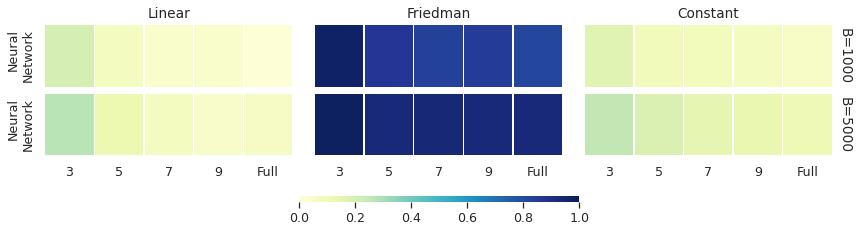

In [ ]:
from scipy.stats.morestats import BartlettResult
# comparison of RF and NN
def generate_plot(model_type,B):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 5
    open_file = open("data/RF_"+model_type+"_B_"+str(n_estimators)+"_test5.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()
    open_file = open("data/NN_"+model_type+"_test5.pkl", "rb")
    result_nn = pickle.load(open_file)
    open_file.close()

    param_dict = ["3","5","7","9","Full"]
    power_mat = np.zeros([1,len(param_dict)])
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        for j in range(len(result_ls)):
            cov_ij1,cov_ijc1, cov_c1, cov_bias1, U_ij1, V1, V_bias1 = result_ls[j]
            cov2, U_ij2, V2 = result_nn[i]
            pvalue = model_comp_test_assemble(V1,np.array(V2[0]),cov_c1,cov2[0],U_ij1,U_ij2[0],N)
            if pvalue<0.05:
                power_mat[:,j] += 1/len(result_rf)
    return power_mat

power_mat1 = generate_plot("linear",1000)
power_mat2 = generate_plot("friedman",1000)
power_mat3 = generate_plot("constant",1000)
power_mat4 = generate_plot("linear",5000)
power_mat5 = generate_plot("friedman",5000)
power_mat6 = generate_plot("constant",5000)
power_mat = [power_mat1,power_mat2,power_mat3,power_mat4,power_mat5,power_mat6]

param_dict = ["3","5","7","9","Full"]
d = {'xlab':[],'ylab':[],'model_type':[],'B':[],'count':[]}
data = pd.DataFrame(data=d)
c = 0
i = 0
for B in ["B=1000","B=5000"]:
    for model_type in ["Linear","Friedman","Constant"]:
        for j in range(len(param_dict)):
            data.loc[c] = [param_dict[j],'Neural\nNetwork',model_type,B,power_mat[i][0,j]]
            c += 1
        i +=1

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='ylab', columns="xlab", values='count')
    sns.heatmap(data, linewidth=0.5, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"}, **kws)  # <-- Pass kwargs to heatmap

sns.set(font_scale=1.15)
g = sns.FacetGrid(data, col="model_type", row="B", margin_titles=True, despine=False)

cbar_ax = g.fig.add_axes([0.38, -0.15, .3, .04])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1)  # <-- Specify the colorbar axes and limits
g.set(xlabel=None)
g.set(ylabel=None)
g.fig.set_figwidth(13)
g.fig.set_figheight(2.3)
g.set_titles(row_template="{row_name}",col_template="{col_name}", fontsize=30)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


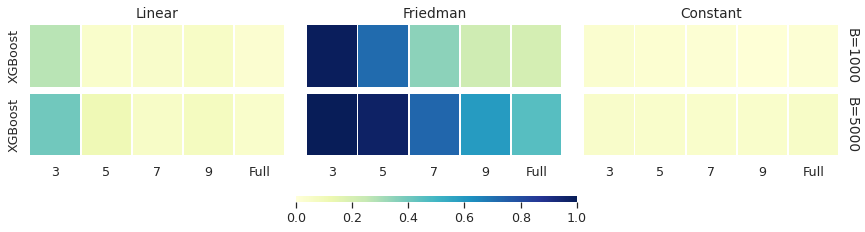

In [ ]:
from scipy.stats.morestats import BartlettResult
# comparison of RF and XGboost
def generate_plot(model_type,B):
    N = 1000
    s_frac = 0.2
    n_estimators = B
    n_test = 5
    open_file = open("data/RF_"+model_type+"_B_"+str(n_estimators)+"_test5.pkl", "rb")
    result_rf = pickle.load(open_file)
    open_file.close()
    open_file = open("data/XGB_"+model_type+"_B_1000_test5.pkl", "rb")
    result_nn = pickle.load(open_file)
    open_file.close()

    param_dict = ["3","5","7","9","Full"]
    power_mat = np.zeros([1,len(param_dict)])
    for i in range(len(result_rf)):
        result_ls = result_rf[i]
        for j in range(len(result_ls)):
            cov_ij1,cov_ijc1, cov_c1, cov_bias1, U_ij1, V1, V_bias1 = result_ls[j]
            cov_ij2,cov_ijc2, cov_c2, U_ij2, V2  = result_nn[i]
            pvalue = model_comp_test_assemble(V1,V2,cov_c1,cov_c2,U_ij1,U_ij2,N)
            if pvalue<0.05:
                power_mat[:,j] += 1/len(result_rf)
    return power_mat

power_mat1 = generate_plot("linear",1000)
power_mat2 = generate_plot("friedman",1000)
power_mat3 = generate_plot("constant",1000)
power_mat4 = generate_plot("linear",5000)
power_mat5 = generate_plot("friedman",5000)
power_mat6 = generate_plot("constant",5000)
power_mat = [power_mat1,power_mat2,power_mat3,power_mat4,power_mat5,power_mat6]

param_dict = ["3","5","7","9","Full"]
d = {'xlab':[],'ylab':[],'model_type':[],'B':[],'count':[]}
data = pd.DataFrame(data=d)
c = 0
i = 0
for B in ["B=1000","B=5000"]:
    for model_type in ["Linear","Friedman","Constant"]:
        for j in range(len(param_dict)):
            data.loc[c] = [param_dict[j],'XGBoost',model_type,B,power_mat[i][0,j]]
            c += 1
        i +=1

def facet_heatmap(data, color, **kws):
    data = data.pivot(index='ylab', columns="xlab", values='count')
    sns.heatmap(data, linewidth=0.5, cmap="YlGnBu",cbar_kws={"orientation": "horizontal"}, **kws)  # <-- Pass kwargs to heatmap

sns.set(font_scale=1.15)
g = sns.FacetGrid(data, col="model_type", row="B", margin_titles=True, despine=False)

cbar_ax = g.fig.add_axes([0.37, -0.15, .3, .04])  # <-- Create a colorbar axes

g = g.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax,
                    vmin=0, vmax=1)  # <-- Specify the colorbar axes and limits
g.set(xlabel=None)
g.set(ylabel=None)
g.fig.set_figwidth(13)
g.fig.set_figheight(2.3)
g.set_titles(row_template="{row_name}",col_template="{col_name}", fontsize=30)